# Detección automática de cianobacterias mediante espectroscopía Raman
## Análisis de los datos usando Machine Learning

### 1. Carga paquetes

In [102]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import label_binarize
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import seaborn as sns

### 2. Carga archivos preprocesados

In [103]:
# Cargamos los csv ya filtrados de los 3 espectros
UAM253 = pd.read_csv('UAM253.csv')
UAM502 = pd.read_csv('UAM502.csv')
UAM588 = pd.read_csv('UAM588.csv')

### 3. Análisis

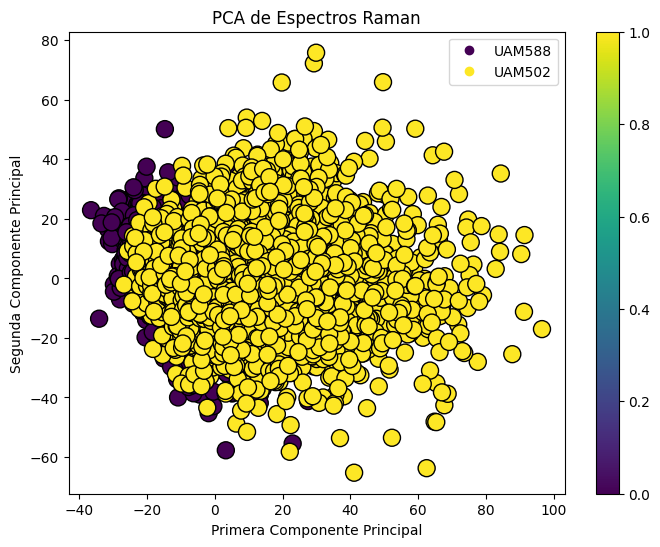

Varianza explicada por cada componente principal: [0.27534841 0.13655408]


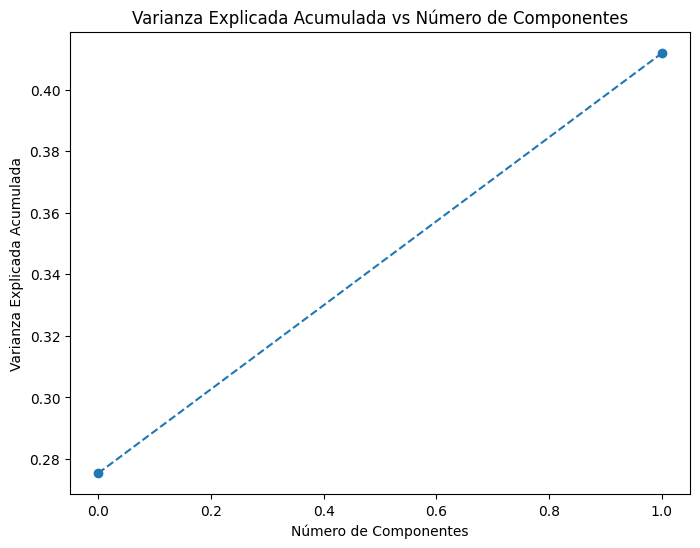

In [104]:
# PCA 2 especies
# Crear etiquetas para las especies
labels_588 = np.zeros(UAM588.shape[0])
labels_502 = np.ones(UAM502.shape[0])

# Combinar los datos y las etiquetas
X = np.vstack((UAM588, UAM502))
y = np.hstack((labels_588, labels_502))

# Estandarizar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Aplicar PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Visualizar los resultados
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', edgecolor='k', s=150)
plt.xlabel('Primera Componente Principal')
plt.ylabel('Segunda Componente Principal')
plt.title('PCA de Espectros Raman')
plt.legend(handles=scatter.legend_elements()[0], labels=['UAM588', 'UAM502'])
plt.colorbar()
plt.show()

# Varianza explicada
explained_variance = pca.explained_variance_ratio_
print("Varianza explicada por cada componente principal:", explained_variance)

# Gráfico de Scree
plt.figure(figsize=(8, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
plt.xlabel('Número de Componentes')
plt.ylabel('Varianza Explicada Acumulada')
plt.title('Varianza Explicada Acumulada vs Número de Componentes')
plt.show()

Número de componentes necesarios para explicar al menos el 80% de la varianza: 74


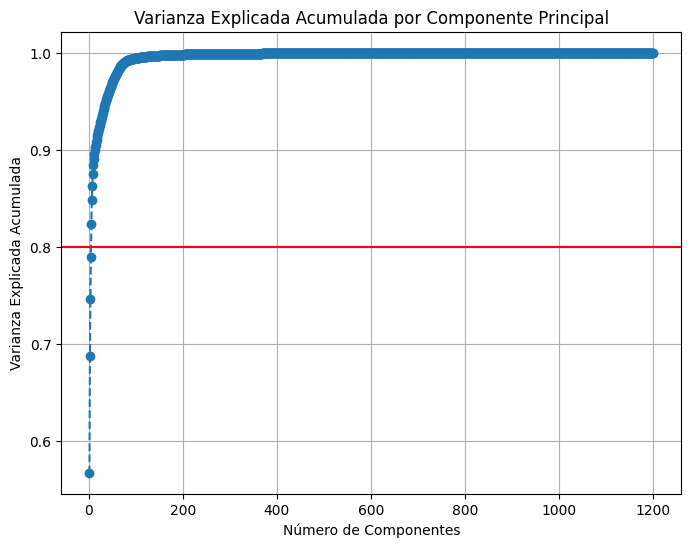

In [105]:
# Aplicar PCA sin especificar el número de componentes
pca = PCA()
X_pca = pca.fit_transform(X)

# Calcular la varianza explicada acumulada
varianza_explicada_acumulada = np.cumsum(pca.explained_variance_ratio_)

# Encontrar el número de componentes que explican al menos el 80% de la varianza
num_componentes = np.argmax(varianza_explicada_acumulada >= 0.99) + 1

print(f"Número de componentes necesarios para explicar al menos el 80% de la varianza: {num_componentes}")


# Visualizar la varianza explicada acumulada
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(varianza_explicada_acumulada) + 1), varianza_explicada_acumulada, marker='o', linestyle='--')
plt.axhline(y=0.80, color='r', linestyle='-')
plt.title('Varianza Explicada Acumulada por Componente Principal')
plt.xlabel('Número de Componentes')
plt.ylabel('Varianza Explicada Acumulada')
plt.grid()
plt.show()

Precisión: 0.9412
              precision    recall  f1-score   support

      UAM502       0.93      0.96      0.95      1325
      UAM588       0.95      0.91      0.93      1039

    accuracy                           0.94      2364
   macro avg       0.94      0.94      0.94      2364
weighted avg       0.94      0.94      0.94      2364

[[1276   49]
 [  90  949]]
Importancia de las características:
1. 1788: 0.0310
2. 1792: 0.0292
3. 1774: 0.0282
4. 1780: 0.0267
5. 1779: 0.0264
6. 1790: 0.0259
7. 1789: 0.0249
8. 1785: 0.0224
9. 1782: 0.0205
10. 1791: 0.0198
11. 1783: 0.0198
12. 1793: 0.0195
13. 1776: 0.0176
14. 1767: 0.0156
15. 1751: 0.0133
16. 1796: 0.0130
17. 1775: 0.0122
18. 1761: 0.0111
19. 1763: 0.0107
20. 1768: 0.0105
21. 1781: 0.0102
22. 1757: 0.0101
23. 1786: 0.0096
24. 1787: 0.0095
25. 1738: 0.0088
26. 1739: 0.0087
27. 1784: 0.0081
28. 1794: 0.0071
29. 1795: 0.0069
30. 1760: 0.0063
31. 1765: 0.0062
32. 1762: 0.0060
33. 1799: 0.0059
34. 1770: 0.0059
35. 1764: 0.0057
36. 14

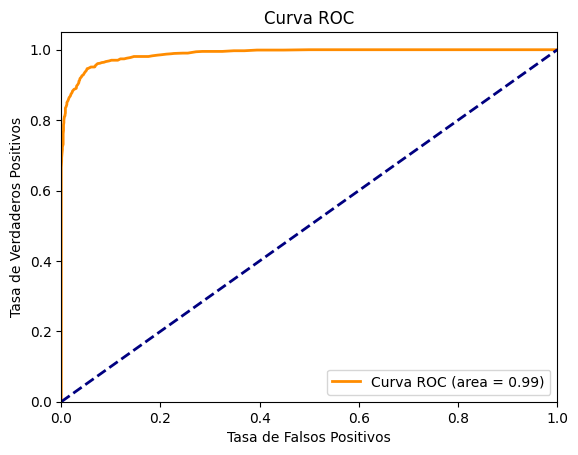

In [106]:
UAM588_2= UAM588.copy()
UAM502_2= UAM502.copy()
# Añadimos una columna para indicar la especie
UAM588_2['species'] = 'UAM588'
UAM502_2['species'] = 'UAM502'

# Combinamos los DataFrames
data = pd.concat([UAM588_2, UAM502_2], ignore_index=True)

# Convertimos las etiquetas de las especies a valores numéricos
label_encoder = LabelEncoder()
data['species'] = label_encoder.fit_transform(data['species'])

# Separar características y etiquetas
X = data.drop(columns=['species'])
y = data['species']

# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

# Crear el modelo Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Entrenar el modelo
rf_model.fit(X_train, y_train)

# Hacer predicciones en el conjunto de prueba
y_pred = rf_model.predict(X_test)
y_prob = rf_model.predict_proba(X_test)[:, 1]  # Probabilidades para la curva ROC

# Calcular la precisión del modelo
accuracy = accuracy_score(y_test, y_pred)
print(f'Precisión: {accuracy:.4f}')

# Mostrar el informe de clasificación
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Mostrar la matriz de confusión
print(confusion_matrix(y_test, y_pred))

# Importancia de las características
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X.columns

print("Importancia de las características:")
for f in range(X.shape[1]):
    print(f"{f + 1}. {feature_names[indices[f]]}: {importances[indices[f]]:.4f}")

# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()


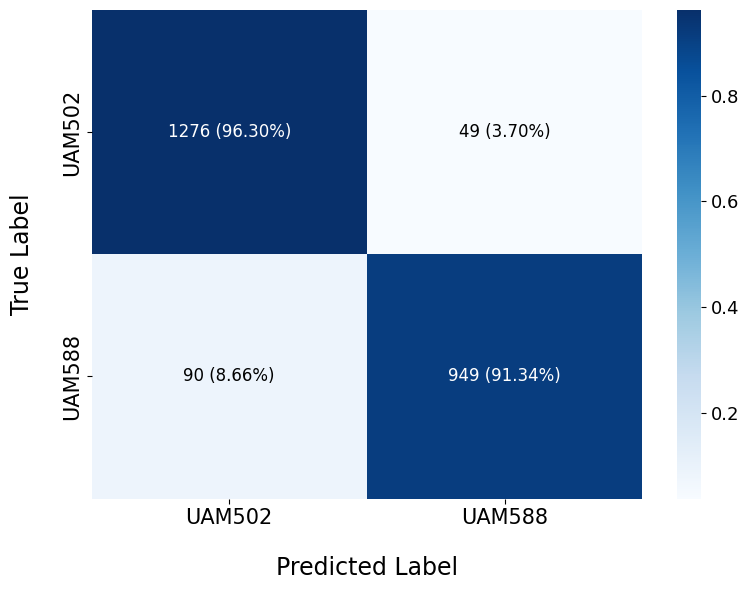

Importancia de las características:
1. 1788: 0.0310
2. 1792: 0.0292
3. 1774: 0.0282
4. 1780: 0.0267
5. 1779: 0.0264
6. 1790: 0.0259
7. 1789: 0.0249
8. 1785: 0.0224
9. 1782: 0.0205
10. 1791: 0.0198
11. 1783: 0.0198
12. 1793: 0.0195
13. 1776: 0.0176
14. 1767: 0.0156
15. 1751: 0.0133
16. 1796: 0.0130
17. 1775: 0.0122
18. 1761: 0.0111
19. 1763: 0.0107
20. 1768: 0.0105
21. 1781: 0.0102
22. 1757: 0.0101
23. 1786: 0.0096
24. 1787: 0.0095
25. 1738: 0.0088
26. 1739: 0.0087
27. 1784: 0.0081
28. 1794: 0.0071
29. 1795: 0.0069
30. 1760: 0.0063
31. 1765: 0.0062
32. 1762: 0.0060
33. 1799: 0.0059
34. 1770: 0.0059
35. 1764: 0.0057
36. 1494: 0.0056
37. 1766: 0.0053
38. 1754: 0.0051
39. 1750: 0.0049
40. 1749: 0.0047
41. 1752: 0.0047
42. 1490: 0.0047
43. 1748: 0.0046
44. 919: 0.0045
45. 915: 0.0045
46. 1733: 0.0045
47. 1732: 0.0045
48. 1736: 0.0045
49. 1721: 0.0041
50. 1728: 0.0041
51. 920: 0.0040
52. 1493: 0.0039
53. 1498: 0.0038
54. 917: 0.0037
55. 1131: 0.0036
56. 1290: 0.0036
57. 1719: 0.0036
58. 1287

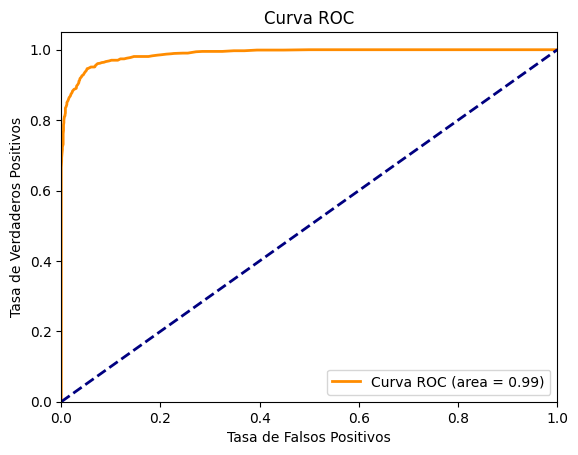

In [107]:
# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)  # Normalizar por sumas de filas

# Visualización de la matriz de confusión normalizada
fig, ax = plt.subplots(figsize=(8, 6))
sns_heatmap = sns.heatmap(cm_normalized, annot=False, fmt='.2%', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        value = cm[i, j]
        if value != 0 and not np.isnan(cm_normalized[i, j]):
            text = f"{value} ({cm_normalized[i, j] * 100:.2f}%)"
            # Elegir el color del texto basado en el valor de fondo
            text_color = "white" if cm_normalized[i, j] > 0.5 else "black"
            plt.annotate(text, (j + 0.5, i + 0.5), ha='center', va='center', color=text_color, fontsize=12)

ax.set_xlabel('Predicted Label', fontsize=17, labelpad=20)
ax.set_ylabel('True Label', fontsize=17, labelpad=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
cbar = sns_heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=13)
plt.tight_layout()
fig.savefig('fig9.svg', format='svg', dpi=300)
plt.show()

# Importancia de las características
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X.columns

print("Importancia de las características:")
for f in range(X.shape[1]):
    print(f"{f + 1}. {feature_names[indices[f]]}: {importances[indices[f]]:.4f}")

# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

In [108]:

# Inicializar el clasificador SVM
svm_classifier = SVC(kernel='rbf', gamma='scale', random_state=42)

# Entrenar el modelo SVM
svm_classifier.fit(X_train, y_train)

# Predecir en el conjunto de prueba
y_pred_svm = svm_classifier.predict(X_test)

# Evaluar el modelo SVM
print("Resultados SVM:")
print(confusion_matrix(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))
print(f"Precisión: {accuracy_score(y_test, y_pred_svm):.4f}")

Resultados SVM:
[[1265   60]
 [  99  940]]
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      1325
           1       0.94      0.90      0.92      1039

    accuracy                           0.93      2364
   macro avg       0.93      0.93      0.93      2364
weighted avg       0.93      0.93      0.93      2364

Precisión: 0.9327


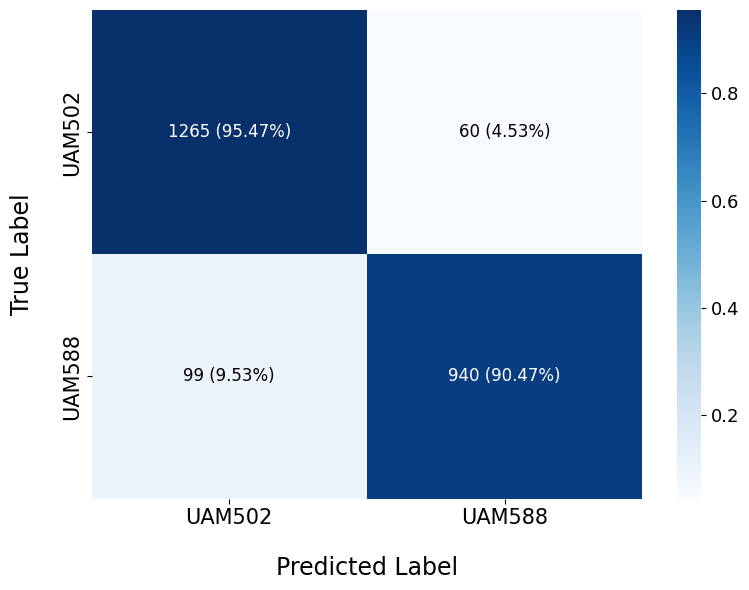

In [109]:
# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_pred_svm)
cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)  # Normalizar por sumas de filas

# Visualización de la matriz de confusión normalizada
fig, ax = plt.subplots(figsize=(8, 6))
sns_heatmap = sns.heatmap(cm_normalized, annot=False, fmt='.2%', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        value = cm[i, j]
        if value != 0 and not np.isnan(cm_normalized[i, j]):
            text = f"{value} ({cm_normalized[i, j] * 100:.2f}%)"
            # Elegir el color del texto basado en el valor de fondo
            text_color = "white" if cm_normalized[i, j] > 0.5 else "black"
            plt.annotate(text, (j + 0.5, i + 0.5), ha='center', va='center', color=text_color, fontsize=12)

ax.set_xlabel('Predicted Label', fontsize=17, labelpad=20)
ax.set_ylabel('True Label', fontsize=17, labelpad=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
cbar = sns_heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=13)
plt.tight_layout()
fig.savefig('svm_confusion_matrix.svg', format='svg', dpi=300)
plt.show()


In [110]:

# Dividir los datos escalados en conjunto de entrenamiento y prueba
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X_scaled, y, test_size=0.30, random_state=42)
# Inicializar la red neuronal
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compilar el modelo
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Entrenar el modelo
history = model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

# Evaluar el modelo en el conjunto de prueba
y_pred_nn = (model.predict(X_test_scaled) > 0.5).astype("int32")  # Convertir las probabilidades a clases binarias

# Mostrar métricas de evaluación
print("\nResultados Red Neuronal:")
print(confusion_matrix(y_test, y_pred_nn))
print(classification_report(y_test, y_pred_nn))
print(f"Precisión: {accuracy_score(y_test, y_pred_nn):.4f}")

Epoch 1/50
138/138 [==============================] - 1s 4ms/step - loss: 0.1700 - accuracy: 0.9272 - val_loss: 0.1436 - val_accuracy: 0.9438
Epoch 2/50
138/138 [==============================] - 0s 3ms/step - loss: 0.0941 - accuracy: 0.9646 - val_loss: 0.1191 - val_accuracy: 0.9538
Epoch 3/50
138/138 [==============================] - 0s 3ms/step - loss: 0.0696 - accuracy: 0.9730 - val_loss: 0.1696 - val_accuracy: 0.9402
Epoch 4/50
138/138 [==============================] - 0s 3ms/step - loss: 0.0572 - accuracy: 0.9776 - val_loss: 0.1265 - val_accuracy: 0.9520
Epoch 5/50
138/138 [==============================] - 0s 3ms/step - loss: 0.0344 - accuracy: 0.9871 - val_loss: 0.1143 - val_accuracy: 0.9611
Epoch 6/50
138/138 [==============================] - 0s 3ms/step - loss: 0.0279 - accuracy: 0.9887 - val_loss: 0.1314 - val_accuracy: 0.9556
Epoch 7/50
138/138 [==============================] - 0s 3ms/step - loss: 0.0201 - accuracy: 0.9923 - val_loss: 0.1062 - val_accuracy: 0.9611
Epoch 

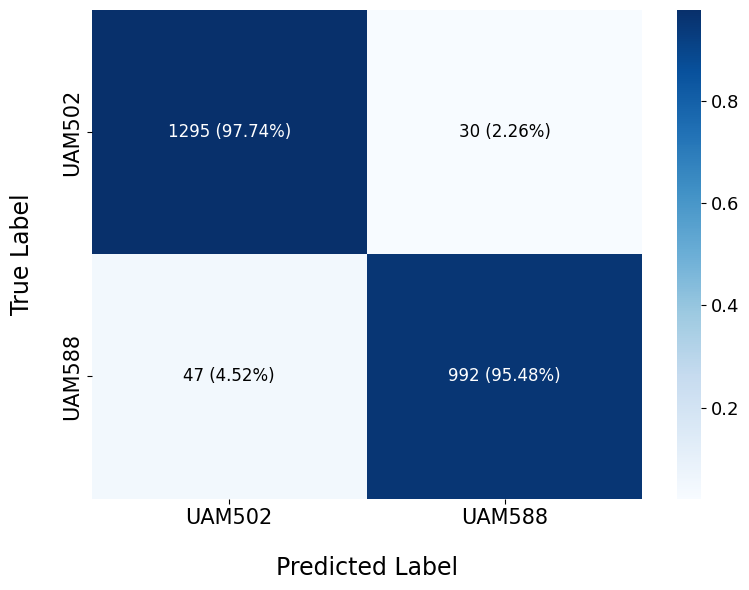

In [111]:

# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_pred_nn)
cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)  # Normalizar por sumas de filas

# Visualización de la matriz de confusión normalizada
fig, ax = plt.subplots(figsize=(8, 6))
sns_heatmap = sns.heatmap(cm_normalized, annot=False, fmt='.2%', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        value = cm[i, j]
        if value != 0 and not np.isnan(cm_normalized[i, j]):
            text = f"{value} ({cm_normalized[i, j] * 100:.2f}%)"
            # Elegir el color del texto basado en el valor de fondo
            text_color = "white" if cm_normalized[i, j] > 0.5 else "black"
            plt.annotate(text, (j + 0.5, i + 0.5), ha='center', va='center', color=text_color, fontsize=12)

ax.set_xlabel('Predicted Label', fontsize=17, labelpad=20)
ax.set_ylabel('True Label', fontsize=17, labelpad=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
cbar = sns_heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=13)
plt.tight_layout()
fig.savefig('nn_confusion_matrix.svg', format='svg', dpi=300)
plt.show()

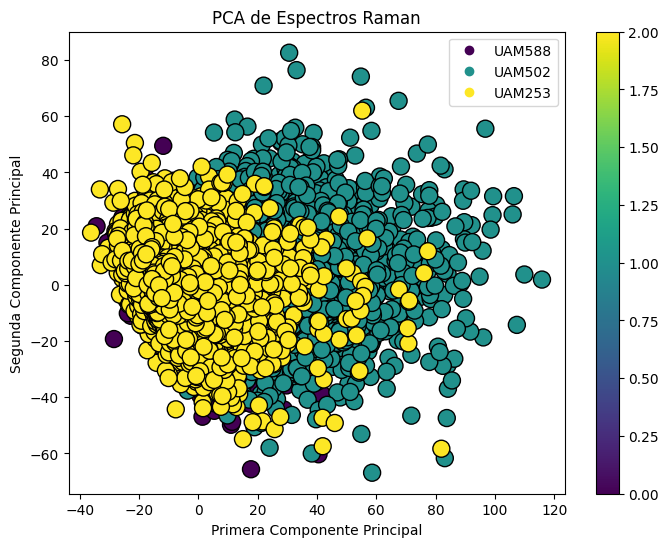

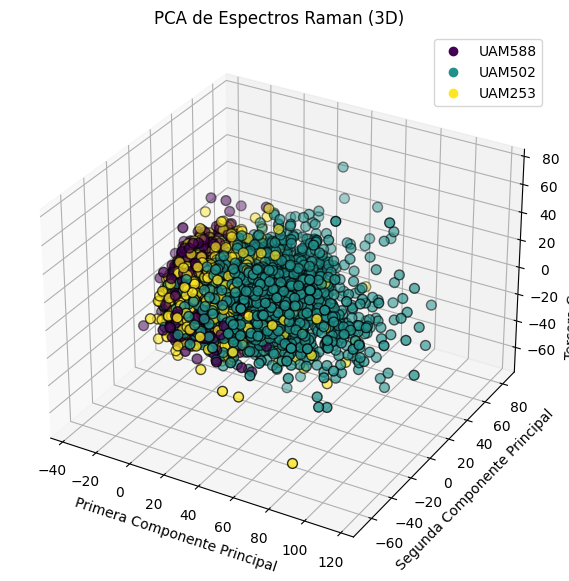

Varianza explicada por cada componente principal: [0.25373866 0.13155153 0.0925697 ]


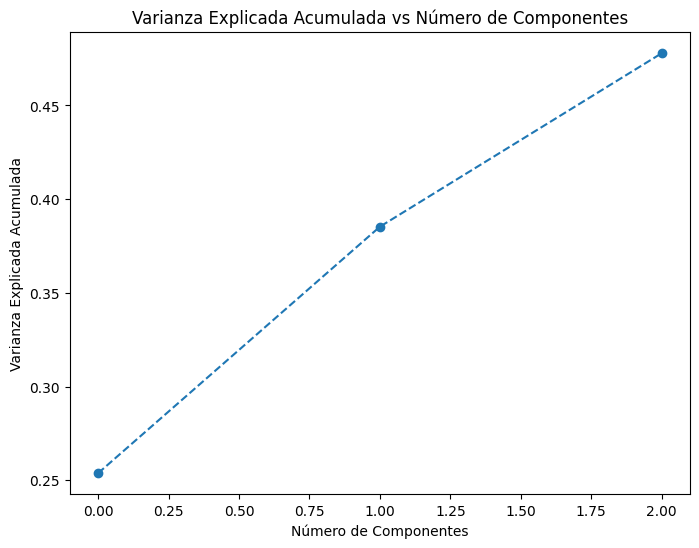

In [112]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

labels_588 = np.zeros(UAM588.shape[0])
labels_502 = np.ones(UAM502.shape[0])
labels_253 = np.full(UAM253.shape[0], 2)

# Combinar los datos y las etiquetas
X = pd.concat([UAM588, UAM502, UAM253], ignore_index=True)
y = np.hstack((labels_588, labels_502, labels_253))

# Estandarizar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Aplicar PCA con 3 componentes
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

# Visualizar los resultados en 2D
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', edgecolor='k', s=150)
plt.xlabel('Primera Componente Principal')
plt.ylabel('Segunda Componente Principal')
plt.title('PCA de Espectros Raman')
plt.legend(handles=scatter.legend_elements()[0], labels=['UAM588', 'UAM502', 'UAM253'])
plt.colorbar()
plt.show()

# Visualizar los resultados en 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=y, cmap='viridis', edgecolor='k', s=50)
ax.set_xlabel('Primera Componente Principal')
ax.set_ylabel('Segunda Componente Principal')
ax.set_zlabel('Tercera Componente Principal')
plt.title('PCA de Espectros Raman (3D)')
plt.legend(handles=scatter.legend_elements()[0], labels=['UAM588', 'UAM502', 'UAM253'])
plt.show()

# Varianza explicada
explained_variance = pca.explained_variance_ratio_
print("Varianza explicada por cada componente principal:", explained_variance)

# Gráfico de Scree
plt.figure(figsize=(8, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
plt.xlabel('Número de Componentes')
plt.ylabel('Varianza Explicada Acumulada')
plt.title('Varianza Explicada Acumulada vs Número de Componentes')
plt.show()

Número de componentes necesarios para explicar al menos el 80% de la varianza: 5


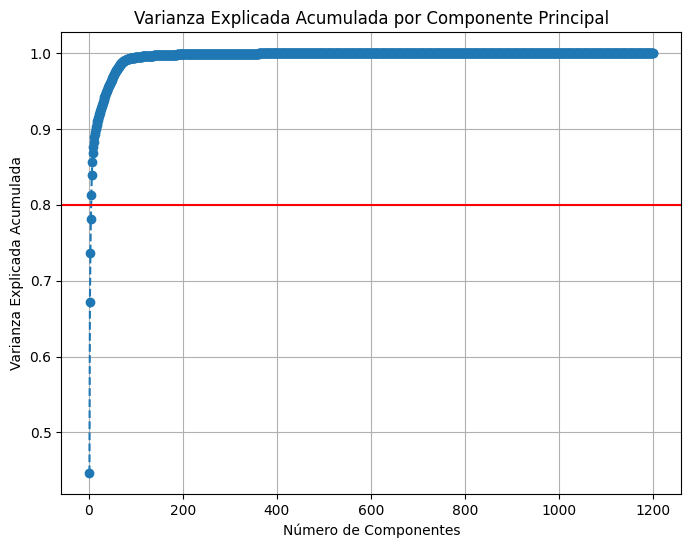

In [113]:
# Aplicar PCA sin especificar el número de componentes
pca = PCA()
X_pca = pca.fit_transform(X)

# Calcular la varianza explicada acumulada
varianza_explicada_acumulada = np.cumsum(pca.explained_variance_ratio_)

# Encontrar el número de componentes que explican al menos el 80% de la varianza
num_componentes = np.argmax(varianza_explicada_acumulada >= 0.80) + 1

print(f"Número de componentes necesarios para explicar al menos el 80% de la varianza: {num_componentes}")


# Visualizar la varianza explicada acumulada
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(varianza_explicada_acumulada) + 1), varianza_explicada_acumulada, marker='o', linestyle='--')
plt.axhline(y=0.80, color='r', linestyle='-')
plt.title('Varianza Explicada Acumulada por Componente Principal')
plt.xlabel('Número de Componentes')
plt.ylabel('Varianza Explicada Acumulada')
plt.grid()
plt.show()

Precisión: 0.9347
              precision    recall  f1-score   support

      UAM253       0.94      0.97      0.95      2448
      UAM502       0.93      0.90      0.91      1369
      UAM588       0.93      0.89      0.91       995

    accuracy                           0.93      4812
   macro avg       0.93      0.92      0.93      4812
weighted avg       0.93      0.93      0.93      4812

[[2384   40   24]
 [ 100 1228   41]
 [  61   48  886]]
Importancia de las características:
1. 1540: 0.0281
2. 1534: 0.0164
3. 1510: 0.0148
4. 1788: 0.0146
5. 1505: 0.0143
6. 1542: 0.0136
7. 1513: 0.0135
8. 1528: 0.0127
9. 1541: 0.0123
10. 1508: 0.0122
11. 1531: 0.0120
12. 1538: 0.0115
13. 1791: 0.0114
14. 1774: 0.0109
15. 1537: 0.0109
16. 1169: 0.0108
17. 1789: 0.0105
18. 1787: 0.0101
19. 1790: 0.0098
20. 1773: 0.0097
21. 1536: 0.0097
22. 1530: 0.0092
23. 1511: 0.0092
24. 1529: 0.0092
25. 1783: 0.0088
26. 1503: 0.0082
27. 1792: 0.0081
28. 1780: 0.0080
29. 1543: 0.0080
30. 1759: 0.0073
31. 1794:

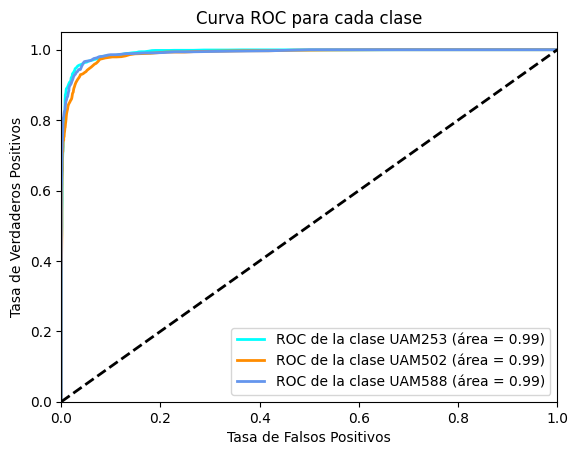

In [114]:
UAM588_2= UAM588.copy()
UAM502_2= UAM502.copy()
UAM253_2= UAM253.copy()
# Añadimos una columna para indicar la especie
UAM588_2['species'] = 'UAM588'
UAM502_2['species'] = 'UAM502'
UAM253_2['species'] = 'UAM253'
# Combinamos los DataFrames
data = pd.concat([UAM588_2, UAM502_2, UAM253_2], ignore_index=True)

# Convertimos las etiquetas de las especies a valores numéricos
label_encoder = LabelEncoder()
data['species'] = label_encoder.fit_transform(data['species'])

# Separar características y etiquetas
X = data.drop(columns=['species'])
y = data['species']

# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Crear el modelo Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Entrenar el modelo
rf_model.fit(X_train, y_train)

# Hacer predicciones en el conjunto de prueba
y_pred = rf_model.predict(X_test)
y_prob = rf_model.predict_proba(X_test)  # Probabilidades para la curva ROC

# Calcular la precisión del modelo
accuracy = accuracy_score(y_test, y_pred)
print(f'Precisión: {accuracy:.4f}')

# Mostrar el informe de clasificación
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Mostrar la matriz de confusión
print(confusion_matrix(y_test, y_pred))

# Importancia de las características
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X.columns

print("Importancia de las características:")
for f in range(X.shape[1]):
    print(f"{f + 1}. {feature_names[indices[f]]}: {importances[indices[f]]:.4f}")

# Curva ROC para múltiples clases
# Binarizamos las etiquetas
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_test_bin.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curve for each class
plt.figure()
colors = ['aqua', 'darkorange', 'cornflowerblue']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC de la clase {label_encoder.classes_[i]} (área = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC para cada clase')
plt.legend(loc="lower right")
plt.show()

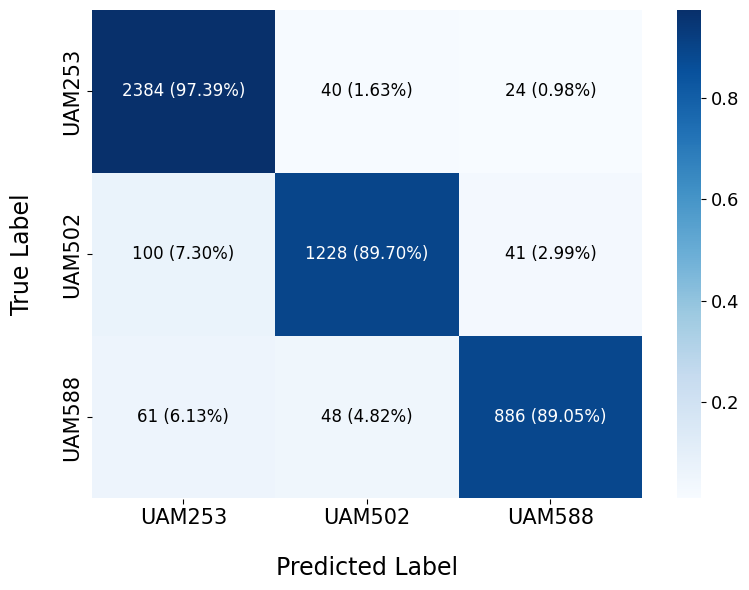

Importancia de las características:
1. 1540: 0.0281
2. 1534: 0.0164
3. 1510: 0.0148
4. 1788: 0.0146
5. 1505: 0.0143
6. 1542: 0.0136
7. 1513: 0.0135
8. 1528: 0.0127
9. 1541: 0.0123
10. 1508: 0.0122
11. 1531: 0.0120
12. 1538: 0.0115
13. 1791: 0.0114
14. 1774: 0.0109
15. 1537: 0.0109
16. 1169: 0.0108
17. 1789: 0.0105
18. 1787: 0.0101
19. 1790: 0.0098
20. 1773: 0.0097
21. 1536: 0.0097
22. 1530: 0.0092
23. 1511: 0.0092
24. 1529: 0.0092
25. 1783: 0.0088
26. 1503: 0.0082
27. 1792: 0.0081
28. 1780: 0.0080
29. 1543: 0.0080
30. 1759: 0.0073
31. 1794: 0.0069
32. 1785: 0.0065
33. 1535: 0.0064
34. 1784: 0.0064
35. 1527: 0.0063
36. 1795: 0.0063
37. 1793: 0.0063
38. 1779: 0.0062
39. 1758: 0.0058
40. 1166: 0.0058
41. 1507: 0.0058
42. 1782: 0.0056
43. 1167: 0.0055
44. 1504: 0.0055
45. 1767: 0.0055
46. 1799: 0.0054
47. 1515: 0.0054
48. 1165: 0.0052
49. 1776: 0.0051
50. 1292: 0.0049
51. 1539: 0.0049
52. 1506: 0.0049
53. 1545: 0.0048
54. 1524: 0.0048
55. 1514: 0.0047
56. 1163: 0.0047
57. 1765: 0.0047
58. 

In [115]:
# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)  # Normalizar por sumas de filas

# Visualización de la matriz de confusión normalizada
fig, ax = plt.subplots(figsize=(8, 6))
sns_heatmap = sns.heatmap(cm_normalized, annot=False, fmt='.2%', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        value = cm[i, j]
        if value != 0 and not np.isnan(cm_normalized[i, j]):
            text = f"{value} ({cm_normalized[i, j] * 100:.2f}%)"
            # Elegir el color del texto basado en el valor de fondo
            text_color = "white" if cm_normalized[i, j] > 0.5 else "black"
            plt.annotate(text, (j + 0.5, i + 0.5), ha='center', va='center', color=text_color, fontsize=12)

ax.set_xlabel('Predicted Label', fontsize=17, labelpad=20)
ax.set_ylabel('True Label', fontsize=17, labelpad=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
cbar = sns_heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=13)
plt.tight_layout()
fig.savefig('fig9.svg', format='svg', dpi=300)
plt.show()

# Importancia de las características
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X.columns

print("Importancia de las características:")
for f in range(X.shape[1]):
    print(f"{f + 1}. {feature_names[indices[f]]}: {importances[indices[f]]:.4f}")



In [116]:
# Dividir los datos en conjunto de entrenamiento y prueba

X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Inicializar el clasificador SVM para un problema multiclase
svm_classifier = SVC(kernel='rbf', gamma='scale', random_state=42)

# Entrenar el modelo SVM
svm_classifier.fit(X_train_scaled, y_train)

# Predecir en el conjunto de prueba
y_pred_svm = svm_classifier.predict(X_test_scaled)

# Evaluar el modelo SVM
print("\nResultados SVM:")
print(confusion_matrix(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))
print(f"Precisión: {accuracy_score(y_test, y_pred_svm):.4f}")


Resultados SVM:
[[2404   34   10]
 [  40 1310   19]
 [  20   42  933]]
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      2448
           1       0.95      0.96      0.95      1369
           2       0.97      0.94      0.95       995

    accuracy                           0.97      4812
   macro avg       0.96      0.96      0.96      4812
weighted avg       0.97      0.97      0.97      4812

Precisión: 0.9657


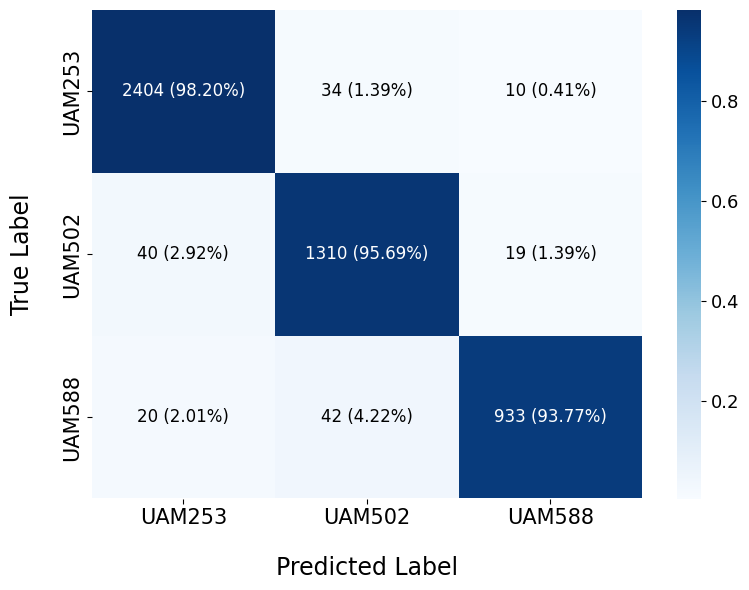

In [117]:
# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_pred_svm)
cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)  # Normalizar por sumas de filas

# Visualización de la matriz de confusión normalizada
fig, ax = plt.subplots(figsize=(8, 6))
sns_heatmap = sns.heatmap(cm_normalized, annot=False, fmt='.2%', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        value = cm[i, j]
        if value != 0 and not np.isnan(cm_normalized[i, j]):
            text = f"{value} ({cm_normalized[i, j] * 100:.2f}%)"
            # Elegir el color del texto basado en el valor de fondo
            text_color = "white" if cm_normalized[i, j] > 0.5 else "black"
            plt.annotate(text, (j + 0.5, i + 0.5), ha='center', va='center', color=text_color, fontsize=12)

ax.set_xlabel('Predicted Label', fontsize=17, labelpad=20)
ax.set_ylabel('True Label', fontsize=17, labelpad=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
cbar = sns_heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=13)
plt.tight_layout()
fig.savefig('svm_confusion_matrix.svg', format='svg', dpi=300)
plt.show()


In [118]:

# Convertir las etiquetas a formato categórico (one-hot encoding)
y_categorical = to_categorical(y, num_classes=3)

# Dividir los datos escalados en conjunto de entrenamiento y prueba
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X_scaled, y_categorical, test_size=0.3, random_state=42)

# Inicializar la red neuronal
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(32, activation='relu'),
    Dense(3, activation='softmax')  # Cambiar a softmax para clasificación multiclase
])

# Compilar el modelo
model.compile(optimizer='adam',
              loss='categorical_crossentropy',  # Cambiar a categorical_crossentropy
              metrics=['accuracy'])

# Entrenar el modelo
model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

# Evaluar el modelo en el conjunto de prueba
y_pred_nn = np.argmax(model.predict(X_test_scaled), axis=1)
y_test_true = np.argmax(y_test, axis=1)

# Mostrar métricas de evaluación
print("\nResultados de la Red Neuronal:")
print(confusion_matrix(y_test_true, y_pred_nn))
print(classification_report(y_test_true, y_pred_nn))
print(f"Precisión: {accuracy_score(y_test_true, y_pred_nn):.4f}")


Epoch 1/50
281/281 [==============================] - 2s 4ms/step - loss: 0.2011 - accuracy: 0.9304 - val_loss: 0.1555 - val_accuracy: 0.9461
Epoch 2/50
281/281 [==============================] - 1s 3ms/step - loss: 0.1029 - accuracy: 0.9624 - val_loss: 0.1514 - val_accuracy: 0.9470
Epoch 3/50
281/281 [==============================] - 1s 3ms/step - loss: 0.0795 - accuracy: 0.9709 - val_loss: 0.1346 - val_accuracy: 0.9563
Epoch 4/50
281/281 [==============================] - 1s 3ms/step - loss: 0.0638 - accuracy: 0.9758 - val_loss: 0.1177 - val_accuracy: 0.9617
Epoch 5/50
281/281 [==============================] - 1s 3ms/step - loss: 0.0564 - accuracy: 0.9803 - val_loss: 0.1214 - val_accuracy: 0.9621
Epoch 6/50
281/281 [==============================] - 1s 3ms/step - loss: 0.0382 - accuracy: 0.9867 - val_loss: 0.1245 - val_accuracy: 0.9612
Epoch 7/50
281/281 [==============================] - 1s 3ms/step - loss: 0.0323 - accuracy: 0.9886 - val_loss: 0.1216 - val_accuracy: 0.9648
Epoch 

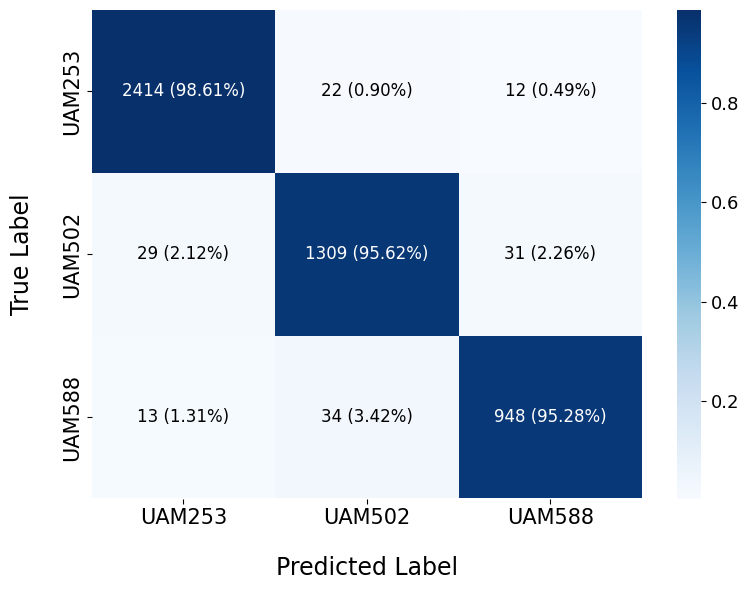

In [121]:
# Calcular la matriz de confusión
cm = confusion_matrix(y_test_true, y_pred_nn)
cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)  # Normalizar por sumas de filas

# Visualización de la matriz de confusión normalizada
fig, ax = plt.subplots(figsize=(8, 6))
sns_heatmap = sns.heatmap(cm_normalized, annot=False, fmt='.2%', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        value = cm[i, j]
        if value != 0 and not np.isnan(cm_normalized[i, j]):
            text = f"{value} ({cm_normalized[i, j] * 100:.2f}%)"
            # Elegir el color del texto basado en el valor de fondo
            text_color = "white" if cm_normalized[i, j] > 0.5 else "black"
            plt.annotate(text, (j + 0.5, i + 0.5), ha='center', va='center', color=text_color, fontsize=12)

ax.set_xlabel('Predicted Label', fontsize=17, labelpad=20)
ax.set_ylabel('True Label', fontsize=17, labelpad=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
cbar = sns_heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=13)
plt.tight_layout()
fig.savefig('nn_confusion_matrix.svg', format='svg', dpi=300)
plt.show()
